In [ ]:
import sys


import skimage
import tensorflow as tf
import cv2
from skimage.transform import resize, rescale
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage import measure
#import measure.compare_ssim as ssim
from skimage.metrics import structural_similarity as ssim


import numpy as np
import math
import os
import matplotlib.pyplot as plt
import time

In [ ]:
srcnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Master_Thesis/SRCNN/SRCNNx4/srcnn_4x.h5')

In [ ]:
srcnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, None, None, 128)   10496     
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 64)    73792     
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def psnr(img1, img2):
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation=cv2.INTER_CUBIC)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
def crop_image(image, crop_coords):
    """
    Crop an image based on the provided coordinates and return the cropped image.
    :param image: NumPy array or PIL Image object representing the input image.
    :param crop_coords: Tuple (left, upper, right, lower) specifying the crop coordinates.
    :return: Cropped image as a NumPy array or PIL Image object.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    cropped_image = image.crop(crop_coords)
    return cropped_image

In [ ]:
input_folder = "/content/drive/MyDrive/Master_Thesis/DATASET/test_dataset/Set14/LRbicx4/"
output_folder = "/content/drive/MyDrive/Master_Thesis/SRCNN/Results/x4/Set14/"
upscale_factor = 4

# Get a list of image file names in the folder
input_files = os.listdir(input_folder)
names = []

# Loop through the image files
for i, image_file in enumerate(input_files):
    # Create the full path to the input image file
    file_name, file_extension = os.path.splitext(image_file)
    image_path = os.path.join(input_folder, image_file)

    # Read the image using OpenCV
    fullimg = cv2.imread(image_path, 3) # input shape

    print("start image",fullimg.shape)
    width = fullimg.shape[0]
    height = fullimg.shape[1]
    img = fullimg

    floatimg = img.astype(np.float32) / 255.0
    imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
    imgY = imgYCbCr[:, :, 0]
    imgY = np.expand_dims(cv2.resize(imgYCbCr[:, :, 0], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
    print("imgY",imgY.shape)

    t0= time.time()
    LR_input = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
    resized_LR_input = cv2.resize(LR_input[0, :, :, 0], (256, 256), interpolation=cv2.INTER_CUBIC)
    resized_LR_input = np.expand_dims(resized_LR_input, axis=-1)
    resized_LR_input = np.expand_dims(resized_LR_input, axis=0)

    t1 = time.time() - t0
    print("Time elapsed: ", t1)
    Y = srcnn_model.predict([LR_input])[0]
    Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
    Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
    HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)

    HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
    HR_image = (HR_image).astype(np.uint8)
    names.append(file_name)
    # Save the output image
    output_name = os.path.join(output_folder + file_name + ".png")
    cv2.imwrite(output_name, HR_image)

start image (120, 123, 3)
imgY (480, 492, 1)
Time elapsed:  0.0009605884552001953
1/1 [==============================] - 1s 1s/step
start image (144, 180, 3)
imgY (576, 720, 1)
Time elapsed:  0.0013530254364013672
1/1 [==============================] - 2s 2s/step
start image (126, 126, 3)
imgY (504, 504, 1)
Time elapsed:  0.0010912418365478516
1/1 [==============================] - 1s 1s/step
start image (72, 87, 3)
imgY (288, 348, 1)
Time elapsed:  0.0010867118835449219
1/1 [==============================] - 0s 462ms/step
start image (90, 60, 3)
imgY (360, 240, 1)
Time elapsed:  0.001687765121459961
1/1 [==============================] - 0s 415ms/step
start image (69, 69, 3)
imgY (276, 276, 1)
Time elapsed:  0.0010559558868408203
1/1 [==============================] - 0s 339ms/step
start image (90, 123, 3)
imgY (360, 492, 1)
Time elapsed:  0.0006468296051025391
1/1 [==============================] - 1s 917ms/step
start image (72, 87, 3)
imgY (288, 348, 1)
Time elapsed:  0.001153230667

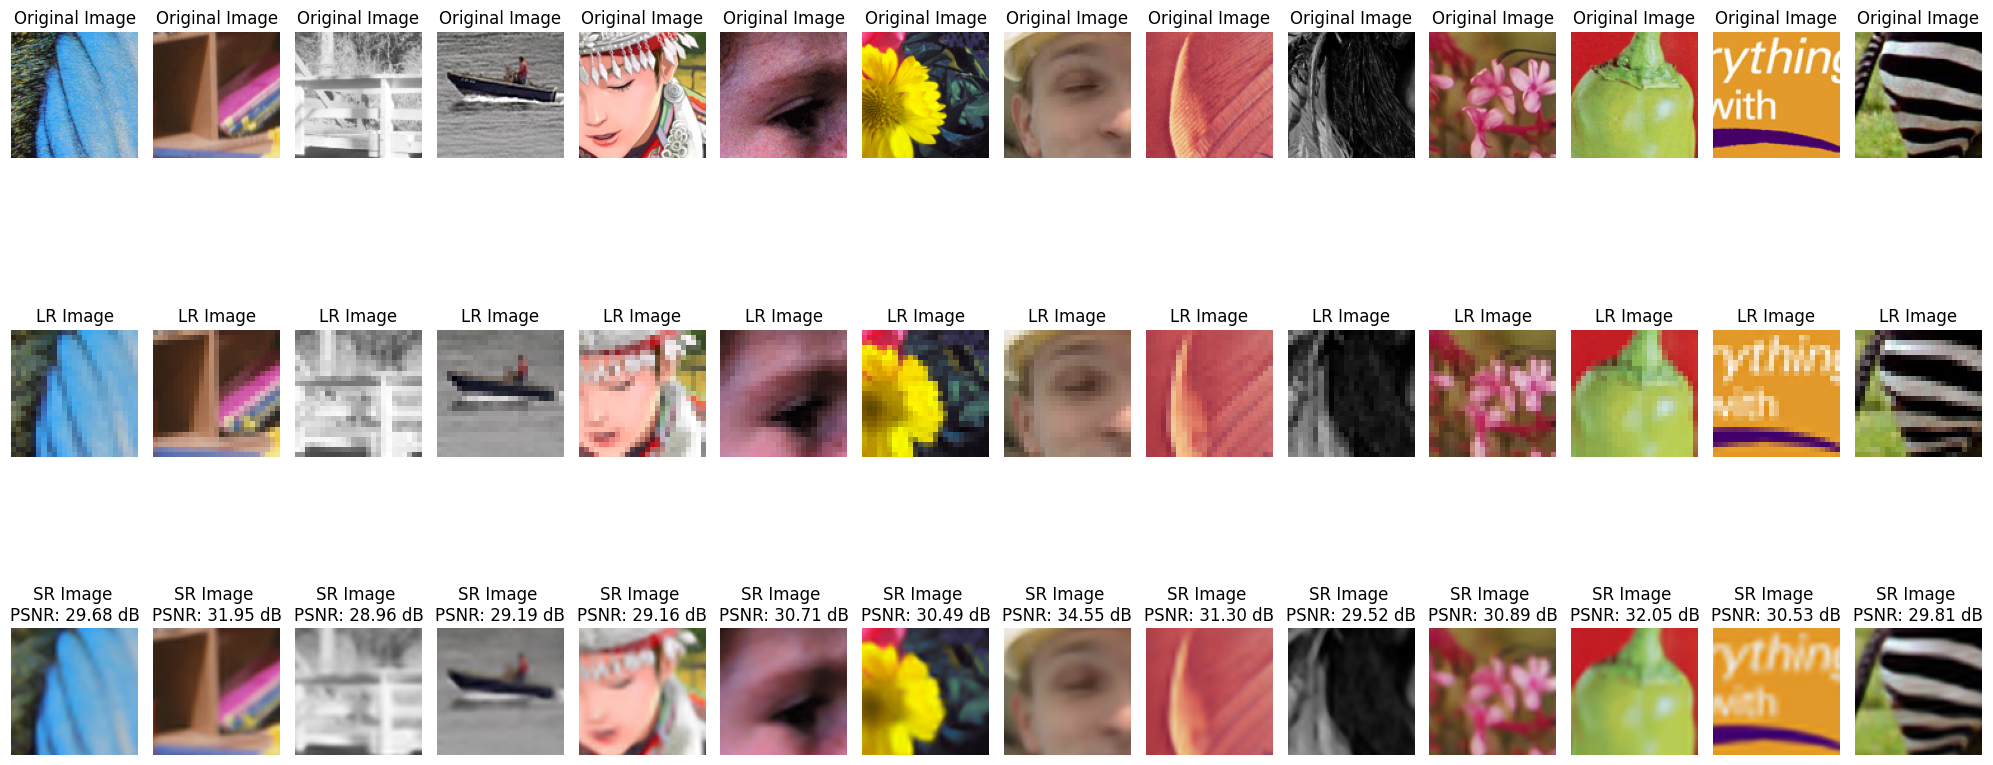

In [ ]:
lr_crop_coords = (25, 25, 50, 50)
SR_HR_coords = (100,100,200,200)

original_folder = "/content/drive/MyDrive/Master_Thesis/DATASET/test_dataset/Set14/original/"

# Get the list of image files in the folders
input_files = os.listdir(input_folder)
original_files = os.listdir(original_folder)
model_pred_files = os.listdir(output_folder)

# Sort the files to ensure consistent order
input_files.sort()
original_files.sort()
model_pred_files.sort()

# Select only the first 5 images
input_files = input_files[:]
original_files = original_files[:]
model_pred_files = model_pred_files[1:]

# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(3, 14, figsize=(20, 10))
psnr_dict={}
# Loop over the images and plot them
for i in range(len(input_files)):
    # Read the LR and HR images
    lr_img = cv2.imread(os.path.join(input_folder, input_files[i]))
    og_img = cv2.imread(os.path.join(original_folder, original_files[i]))
    sr_img = cv2.imread(os.path.join(output_folder, model_pred_files[i]))

    # Convert BGR to RGB for plotting
    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
    og_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
    sr_img = cv2.cvtColor(sr_img, cv2.COLOR_BGR2RGB)

    #Crop Images
    lr_img = crop_image(lr_img, lr_crop_coords)
    og_img = crop_image(og_img, SR_HR_coords)
    sr_img = crop_image(sr_img,SR_HR_coords)

    calculate_psnr = psnr(np.array(og_img),np.array(sr_img))
    psnr_dict[names[i]] = calculate_psnr
    # Plot the LR image
    axes[0, i].imshow(og_img)
    axes[0, i].set_title("Original Image")
    axes[0, i].axis("off")

    # Plot the HR image
    axes[1, i].imshow(lr_img)
    axes[1, i].set_title("LR Image")
    axes[1, i].axis("off")

    # Plot the HR image
    axes[2, i].imshow(sr_img)
    axes[2, i].set_title(f"SR Image \nPSNR: {calculate_psnr:.2f} dB")
    axes[2, i].axis("off")
# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Master_Thesis/SRCNN/Results/x4/Set14/SRCNN_Set14_x4_plot_1.png')


In [ ]:
for i, (key, value) in enumerate(psnr_dict.items()):
    print(f"{i}: {key}: {value:.2f} dB")

0: baboon: 29.68 dB
1: barbara: 31.95 dB
2: bridge: 28.96 dB
3: coastguard: 29.19 dB
4: comic: 29.16 dB
5: face: 30.71 dB
6: flowers: 30.49 dB
7: foreman: 34.55 dB
8: lenna: 31.30 dB
9: man: 29.52 dB
10: monarch: 30.89 dB
11: pepper: 32.05 dB
12: ppt3: 30.53 dB
13: zebra: 29.81 dB
